In [124]:
import pandas as pd
import georinex as gr
import misc
from plots import *

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader

In [ ]:
GPS_SAT_L5_ENABLED = [25,1,24,27,30,6,9,3,26,8,10,32,4,18,23,14,11,28]

# Prepare the data

In [2]:
# Load log files
measurements = ['Raw', 'Fix']
logs = []

log = LogReader(device="Google Pixel 7", specifiedTags=measurements, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixel7_20230217095501.txt")
logs.append(log)

log = LogReader(device="Google Pixel Watch", specifiedTags=measurements, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixelWatch_20230814145154.txt")
logs.append(log)

log = LogReader(device="OnePlus Nord 2", specifiedTags=measurements, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_OnePlusNord2_20230303105504.txt")
logs.append(log)

log = LogReader(device="Samsung A52", specifiedTags=measurements, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_SamsungA52_20230317141230.txt")
logs.append(log)

log = LogReader(device="Xiaomi 11T", specifiedTags=measurements, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_Xiaomi11_20230303095606.txt")
logs.append(log)


In [179]:
# load the references
refs = []

time = logs[0].raw['datetime'][0]
ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230480000_01D_30S_MO.rnx',
              tlim=[logs[0].raw['datetime'].iloc[0].isoformat(), logs[0].raw['datetime'].iloc[-1].isoformat()],
              meas=['C1C', 'C5Q', 'C1P', 'C5P', 'C5A'])

In [181]:
ref.count('sv')[['C1C', 'C5Q', 'C1P', 'C5P', 'C5A']].to_pandas().sum(axis=1).to_list()

ref.count('sv')

<xarray.Dataset>
Dimensions:  (time: 70)
Coordinates:
  * time     (time) datetime64[ns] 2023-02-17T08:05:30 ... 2023-02-17T08:40:00
Data variables:
    C1C      (time) int64 39 40 39 40 40 39 39 39 39 ... 39 38 38 38 38 38 38 38
    C5Q      (time) int64 17 17 17 17 17 17 16 16 16 ... 18 17 17 17 17 17 17 17
    C1P      (time) int64 21 21 21 21 21 21 21 21 21 ... 20 20 20 20 20 20 20 20
    C5P      (time) int64 11 11 11 11 11 11 11 11 11 ... 11 11 11 11 11 11 11 11
    C5A      (time) int64 4 4 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4 4

In [3]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log.fix[["2D_error"]] = log.fix.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.fix[["3D_error"]] = log.fix.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

# Results

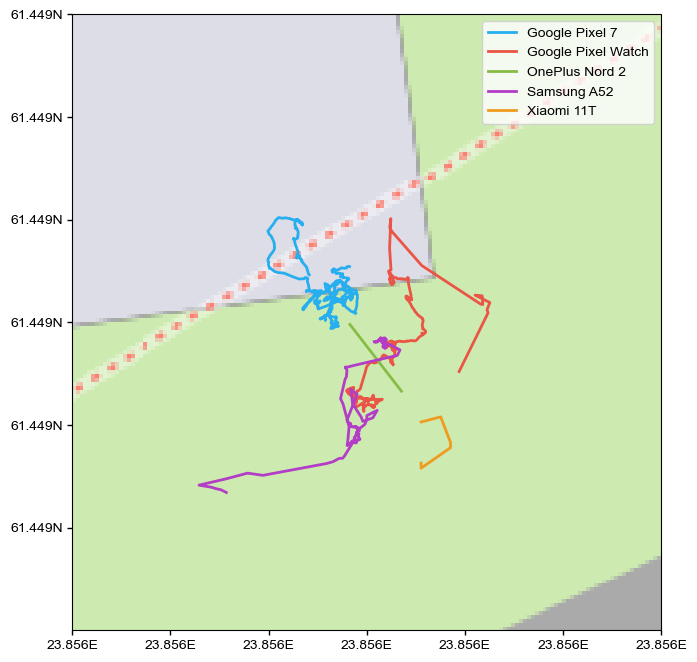

In [4]:
center = ref_enu[:2]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=19)

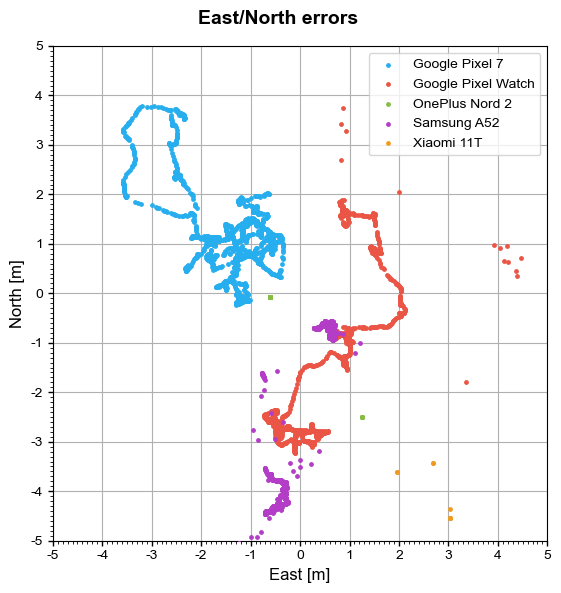

In [5]:
plotEN(logs, lim=5, ticks=[0.1, 1])

### Visibility

In [172]:
def plotTotalSatellitesPerEpochs(logs):

    fig, axs = plt.subplots(1, figsize=(6,5))
    fig.suptitle(f"Total satellites seen per epoch")

    for log in logs:

        df = log.raw[['datetime', 'TimeNanos', 'prn']]
        df = df.groupby('TimeNanos').count()
        df.plot(y='prn', label=log.device, style='o', ms=2, ax=axs)
    

In [116]:
def plotTotalSatellitesBar(logs):

    width = 0.18

    fig, axs = plt.subplots(1, figsize=(6,5))
    fig.suptitle(f"Total satellites seen in")

    x = np.arange(len(logs))
    sats = []
    sats_L1 = []
    sats_L5 = []
    xticks = []

    for ref in refs:
        sats = ref.count('sv')[['C1C', 'C5Q', 'C1P', 'C5P', 'C5A']].to_pandas().sum(axis=1).to_list()
        axs.plot(sats, label=log.device, style='o', ms=2)

    for log in logs:

        _sats = log.raw['prn'].unique()
        _sats_L1 = [x for x in _sats if 'L1' in x]
        _sats_L5 = [x for x in _sats if 'L5' in x]

        sats.append(len(_sats))
        sats_L1.append(len(_sats_L1))
        sats_L5.append(len(_sats_L5))
        xticks.append(log.device)
        
    #axs.bar(x-0.2, sats, width, label='Total')
    axs.bar(x, sats_L1, width, label='L1')
    axs.bar(x, sats_L5, width, bottom=sats_L1, label='L5')
    axs.set_xticks(x, xticks)
    axs.set_axisbelow(True)
    axs.legend()
    fig.tight_layout()

    
    

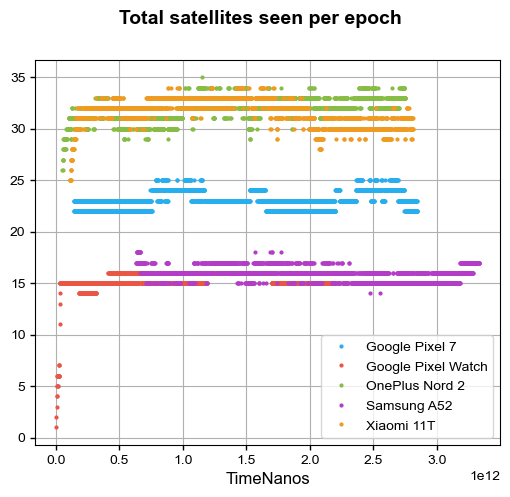

In [174]:
plotTotalSatellitesPerEpochs(logs)

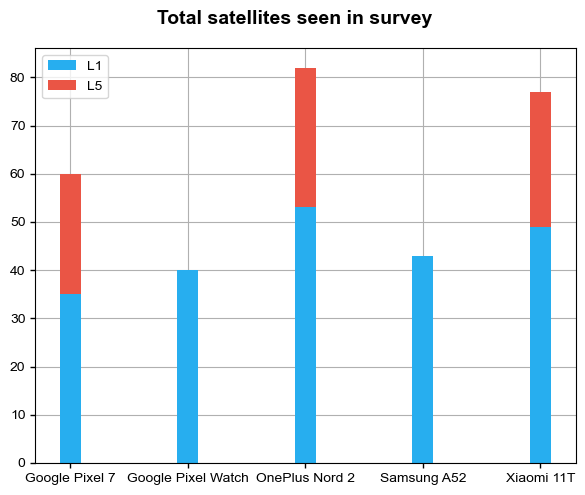

In [117]:
plotTotalSatellitesBar(logs)